# Univariate n-lagged Random Forest  

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input  
> For this univariate model, it was found in the EDA that a lag of one would likely do best.  However the code below does allow for setting a different lag value.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available.
* Predictions are also produced for a "static model" that is fit only once on the training data, and the test data is input in one step to obtain the predictions.  Plots of the predicted and expected values are produced and the MAE is calculated.

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

### Predicting on a Real-Time Fitted Model  

One can imagine two scenarios, generally:  

1.  One where a model is fit on a large and rich set of data, the fit model is used for any new observations that come in, and a model refresh occurs after some set of conditions have been met (time, significant change in process, model performance degradation, etc).

2.  Another where a model is fit also on a fairly large and rich set of data, it generates predictions, but as new observations are recorded, the model is re-fit with the prior history and the new observations, which then generates predictions on a presumably more up-to-date model.

The below presents the second scenario and its results, and below this is the first scenario, "static model" predictions.  Comments on the pitfalls of real-time model refitting are found in the second section.

#### What is the Walk-Forward Validation doing?  

To be clear:  the model is fit to training data for "round 1".  A row from the test set is sent for prediction - no re-training using that or any other test row - and the prediction is stored alongside its corresponding actual test value for error calculation.

Next, that test row is stored to a variable, history, which was already populated with the training set.  Round 2 sends the next row of the test set, but first, the model is re-fit to the history which now contains the original training data set plus the previous row of test data.  As the modelling error was already calculated on that row, we're now considering it as "seen data" and using it to refit the model.  This freshly re-fit model is then used to predict the target on the 2nd (latest) test set row, and the error calculation is done on that result.  

Again, that latest test row is added to the history variable, now growing longer as it gains rows of "seen" test data appended to the training data.  The sequence is taken up again.


Note:  The below is adapted for multivariate forecasting in another notebook.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

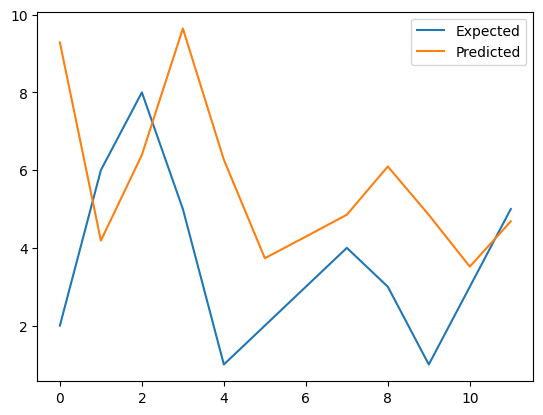

In [3]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

The printout of the arrays above was to check that the output from series_to_supervised is as expected:  first it's a column of the lagged target, then a column of the unlagged target.  Following this around in the code should feed the right things (i.e. not "the answer") to the regressor.  Just checking.

## Trying with a different test set size to see impact on MAE  

Test set size going from 12 to 20.  There's a slight increase in MAE.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

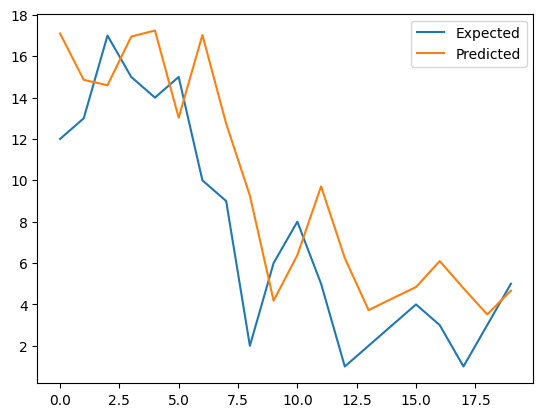

In [1]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 20 to 50.  There's a sharper increase in MAE.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

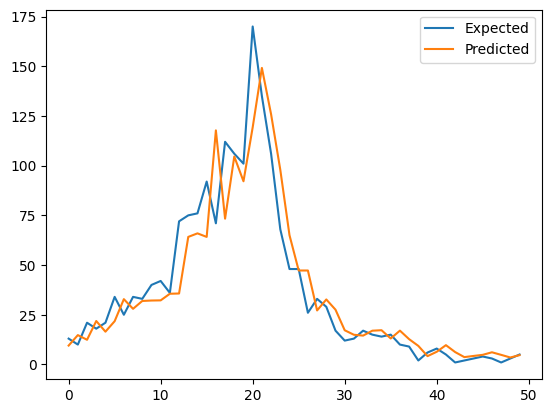

In [2]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 50)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 50 to 100.  

Let's agree that I should probably walk this up to the size of test sets used in the other modelling algorithms.  Interesting:  the MAE dropped a bit wrt the test set of 50.  Hmmmm.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

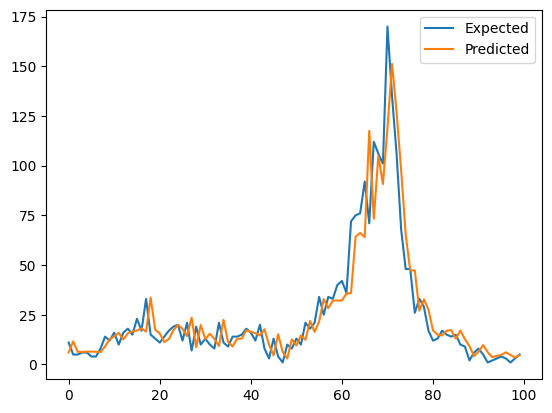

In [3]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 100 to 200.  

I really do need to check what test set size I used on other models... I seem to recall it was ~280 for AutoReg.  I forget for LSTM.  I'll get on it.  

MAE around 7, vs 7.5 at 100 row test set.  Interesting.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

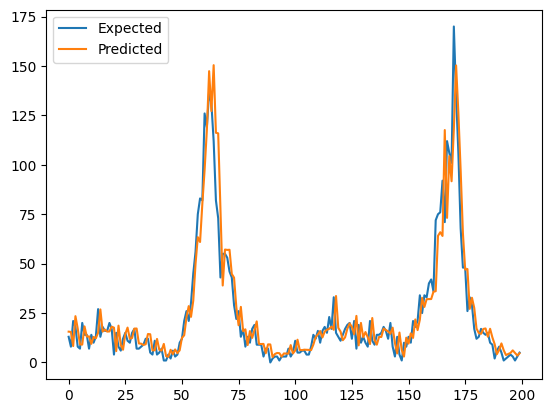

In [4]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 200)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Trying with a different test set size to see impact on MAE  

One last round for fun.  Test set size going from 200 to 300.  

MAE dropped to 6!  Ok, now let's try increasing the test size on the static model.  I'll do it in fewer steps.

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

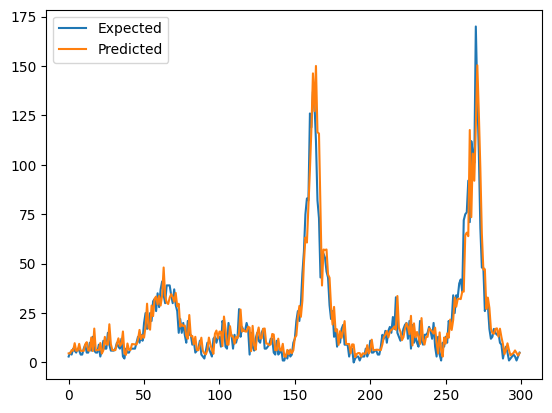

In [5]:
# forecast weekly dengue cases
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
sj_df_cases = sj_df['total_cases']
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()
print(f"Raw total_cases: {sj_df_cases_list}")
# transform the time series data into supervised learning
data = series_to_supervised(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up
# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")				
# evaluate
mae, y, yhat = walk_forward_validation(data, 300)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Predicting on a Static Model  

The below mimics what's done above in the initial set-up where the model is trained on training data (after much processing), but now rather than:
a) feed it one testX row at at time to do a real-time re-fit of the model and generate predictions one step at a time, instead we
b) feed it the entire testX set of rows to get a 'static model' prediction, yhat_static, and get the model error on that  

In many situations, a real-time model re-fit may not be feasible if the computational load is too big, or data cannot be obtained in a timely manner to allow for real-time model updates.  Additionally, real-time model updates come with the additional burden of due diligence:  guardrails must be instituted to ensure 'rogue data' or significant drift in the process being modelled doesn't result in a model that produces significantly erroneous results.  Monitoring error would only be one part of the safeguarding scheme.  There would have to be additional supports like monitoring data quality real-time, among other protections.

Careful not to feed it [test_X], you want to feed it only (test_X) if you're sending it all of testX at a time.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

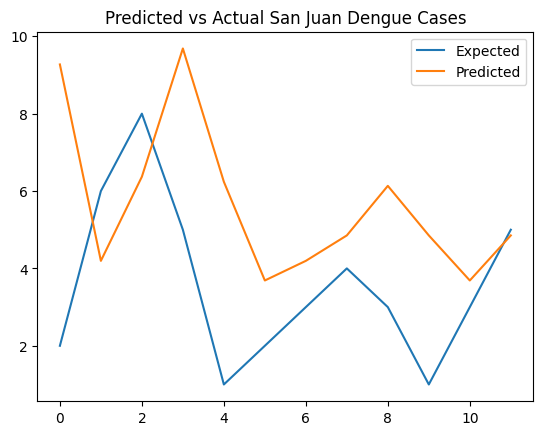

In [7]:
# Pull the data that is output from series_to_supervised
print(data) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data, 12)    
history = [x for x in train]
# basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying a larger test set size for the Dynamic Model  

Going from 12 to 100.  It's fast, it can handle it.  MAE 7.3, up from 2.6 on 12 rows of test data.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

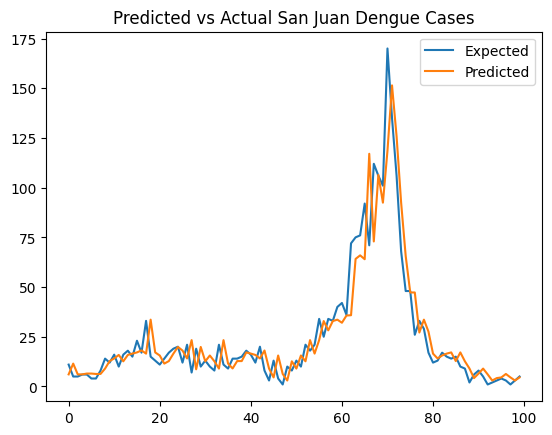

In [8]:
# Pull the data that is output from series_to_supervised
print(data) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data, 100)    
history = [x for x in train]
# basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying a larger test set size for the Dynamic Model  

Going from 100 to 300.  It's fast, it can handle it.  MAE 6.  Cool.  Now let's do this on the multivariate set, but with only the static model.  The dynamic model takes 10 minutes to crunch out 12 rows of test data.  I may just try *one* trial run at 100 or 200 rows of test data on the dynamic multivariate RF model but on Google Colab.  This way perhaps it's not my machine getting heartburn.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

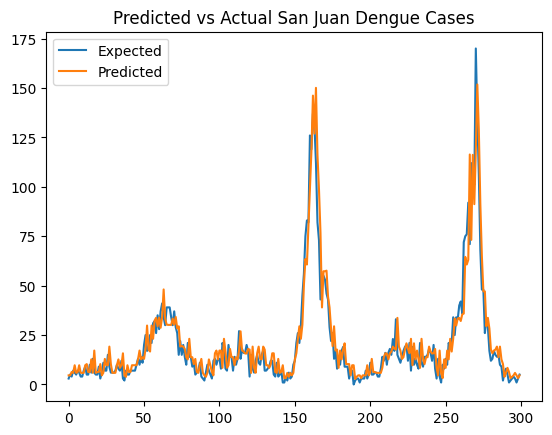

In [9]:
# Pull the data that is output from series_to_supervised
print(data) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data, 300)    
history = [x for x in train]
# basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

In [5]:
# # Just to understand what's being sent to `.predict()` (structure)
#testX

____________________________________________________________________
## Understanding the processing above  

The below repeats what's above, but with a lot of commenting to better understand it, and with some bits and pieces of code trialled under it to really see the outputs from and the inputs to various parts.  It's a sort of "flowchart-in-progress".

In [6]:
# # forecast weekly dengue cases
# from numpy import asarray
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot

# # transform a time series dataset into a supervised learning dataset
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1] # if multivariate, it'll be 'else' and it's the column index for your variables. Not used here.  
# 	df = DataFrame(data)								# you feed this function an array either as a list (y(t) only for AR/UV), or multi-column (y(t) & features)
# 	cols = list()										# so it has no column names anymore (if it did before) and it's turned into a dataframe with numbers for column names
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):						# starts at the highest lag value you specified and will loop down to lag 1 (t-1)
# 		cols.append(df.shift(i))						# shifts/lags entire dataframe of variables (inputs & output variable)
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):							# generally using just y(t), so n_out=1 most often
# 		cols.append(df.shift(-i))						# produces y(t)
# 	# put it all together
# 	agg = concat(cols, axis=1)							# put all the columns together in the same order they were appended in
# 	# drop rows with NaN values; shifting produces NaNs
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg.values									# produces a numpy ndarray (can't get first 5 rows), no column headers (n)

# # split a univariate dataset into train/test sets: retain last "n_test" rows for the test set
# # you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
# def train_test_split(data, n_test):						# could add a parameter f, for fraction, and replace n_test with int(f*len(data))
# 	return data[:-n_test, :], data[-n_test:, :]

# # fit random forest model and make a one step prediction
# def random_forest_forecast(train, testX):
# 	# transform list into array: remember, history is an array of arrays, or list of arrays, each entry of which is [y(t-1), y(t)]
# 	train = asarray(train)
# 	# split into input and output columns
# 	# i.e. input is lagged y's, output is y(t)
# 	trainX, trainy = train[:, :-1], train[:, -1]
# 	# fit model
# 	model = RandomForestRegressor(n_estimators=1000)
# 	model.fit(trainX, trainy)						# it's trying to fit parameters to get yhat to be as close as possible to y(t)/trainy using y(t-1)/trainX
# 	# make a one-step prediction
# 	yhat = model.predict([testX])					# now predict y(t) using testX (last 12/n_test rows of lagged y), and it's only the ith row of the test, so one set of lagged inputs in a time snapshot
# 	return yhat[0]									# why just yhat[0]... it only produces the one prediction on one row of test data, but maybe this was written for cases where there's more
# 													# than just y(t) for outputs.  Someone may wish to model for y(t+k).

# # walk-forward validation for univariate data
# def walk_forward_validation(data, n_test):
# 	predictions = list()
# 	# split dataset
# 	train, test = train_test_split(data, n_test)	# train is first rows up to the last n_test rows, test is the last n_test rows; all columns (inputs & output)
# 	# seed history with training dataset			# train is many rows long by variables (ins & out) wide
# 	history = [x for x in train]					## basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays
# 	# step over each time-step in the test set
# 	for i in range(len(test)):						
# 		# split test row into input and output columns
# 		testX, testy = test[i, :-1], test[i, -1]	# per series_to_supervised, first columns are lagged y, the last column is y(t); not sure how this works if n_out>1; grabbing only the ith row
# 		# fit model on history and make a prediction
# 		yhat = random_forest_forecast(history, testX) # history is the training set of inputs (lagged y) and output (y(t)), testX *here* is ONLY the ith row of the testX set (the last 12 rows (n_test) of lagged y)
# 		# store forecast in list of predictions
# 		predictions.append(yhat)
# 		# add actual observation to history for the next loop
# 		history.append(test[i])						  # it's the one row at test[i], but all columns (y(t-1) and y(t)), appended (so it's added as a list I think) to the training rows already put in earlier
# 		# summarize progress
# 		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
# 	# estimate prediction error
# 	error = mean_absolute_error(test[:, -1], predictions) # I may yet try root mean squared error to match LSTM metric.  Not yet clear why I'd pick one over the other (to do with outlier penalty)
# 	return error, test[:, -1], predictions

# # load the dataset
# sj_df = read_csv('sj_df.csv', header=0, index_col=0)
# data_x = sj_df['total_cases']
# list_x = data_x.values.astype('float32').tolist()
# # transform the time series data into supervised learning
# data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
# print(data)
# # evaluate
# # mae, y, yhat = walk_forward_validation(data, 12)
# # print('MAE: %.3f' % mae)
# # # plot expected vs predicted
# # pyplot.plot(y, label='Expected')
# # pyplot.plot(yhat, label='Predicted')
# # pyplot.legend()
# # pyplot.show()

Testing various bits of code below.  

First, let's examine what we're feeding series_to_supervised.

In [7]:
# test_series = read_csv('sj_df.csv', header=0, index_col=0)
# #test_series # the whole dataframe, obv, as that's what sj_df is
# test_values = test_series.values
# test_values

Now execute the first thing that series_to_supervised does, see the results.

In [8]:
# test_series = read_csv('sj_df.csv', header=0, index_col=0)
# #test_series # the whole dataframe, obv, as that's what sj_df is
# test_values = test_series.values        # effectively strips away the column names, it's no longer set up like a dataframe as we're used to seeing
# #test_values
# # series_to_supervised takes your list or multi-column array and makes into a dataframe of columns with column indices for names
# test_df = DataFrame(test_values)
# test_df

Now let's understand what the history variable looks like, so we can make sense of the walk forward validation.

In [9]:
# # first all this happens:
# sj_df = read_csv('sj_df.csv', header=0, index_col=0)
# data_x = sj_df['total_cases']
# list_x = data_x.values.astype('float32').tolist()
# # transform the time series data into supervised learning
# data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
# #print(data) # 2 columns (y(t-1), y(t)) as expected

# # next, data gets fed to walk_forward_validation along with the test set size (n_test), which is 12 in this case:
# train, test = train_test_split(data, 12) # takes the first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
# # many sanity checks follow.
# #train # outputs as expected: one array of rows, each containing y(t-1) and y(t)
# #len(data)
# #len(train)
# #len(test)
# # test_len_check
# #len(data) - len(train) == len(test) # happy.
# #test # 12 rows, as expected
# history = [x for x in train]
# history # basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array of arrays, I guess
#         # for some reason this gets put back later... see the comments below around the 'asarray' line.

Ok, now let's understand what `.predict()` outputs from the random forest regressor

In [10]:
# # first all this happens:
# sj_df = read_csv('sj_df.csv', header=0, index_col=0)
# data_x = sj_df['total_cases']
# list_x = data_x.values.astype('float32').tolist()

# # transform the time series data into supervised learning
# data = series_to_supervised(list_x, n_in=1) # one time lag for my univariate set-up
# #print(data) # 2 columns (y(t-1), y(t)) as expected

# # next, data gets fed to walk_forward_validation along with the test set size (n_test), which is 12 in this case:
# train, test = train_test_split(data, 12) # takes the first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
# history = [x for x in train]
# history # basically the output of series_to_supervised (data) but each row made into array [y(t-1), y(t)] - it's an array/list of arrays

# # next what happens..
# # for i in range(len(test)), so let's set it to zero.  REMEMBER: for each iteration of this loop, it sends the ONE row of testX (per the range counter) and calls the random forest forecast function
# testX, testy = test[0, :-1], test[0, -1]        # here it's grabbing row i (zero for this case) and assigning the input columns (lagged y) to testX and the output column (y(t)) to testy

# # history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# history = asarray(history)
# #history                 # back to the array we had before with train before it was fed to [x for x in train]?? 2 columns of training data, y(t-1), y(t)
# trainX, trainy = history[:, :-1], history[:, -1] # again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates by lagged y and y
# model = RandomForestRegressor(n_estimators=1000)
# model.fit(trainX, trainy)						# it's trying to fit parameters to get yhat to be as close as possible to y(t)/trainy using y(t-1)/trainX

# # make a one-step prediction
# yhat = model.predict([testX])					# now predict y(t) using testX (last 12/n_test rows of lagged y)
# yhat											# riddle me this... if we're sending the random forest forecast fxn ONE testX row at a time, how's it going to predict more than 1 value for yhat?  So I repeat...
# #return yhat[0]									# why yhat[0]?  Or... does it have to do with possibly setting n_out to something greater than 1 in series_to_supervised? (I'd have to go back over the impact)
